In [ ]:
import os
from datasets import load_dataset

from ragas import EvaluationDataset, evaluate
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import Faithfulness, FactualCorrectness, SemanticSimilarity, ResponseRelevancy

from ragas.llms import LangchainLLMWrapper
# from ragas.embeddings import HuggingfaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()

g:\anaconda\anaconda3\envs\chatbot-agent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [8]:
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0))

In [4]:
# evaluator_embeddings = LangchainEmbeddingsWrapper(HuggingfaceEmbeddings(model="BAAI/bge-m3"))
langchain_hf_embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")
ragas_embeddings = LangchainEmbeddingsWrapper(langchain_hf_embeddings)

g:\anaconda\anaconda3\envs\chatbot-agent\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ADMIN\.cache\huggingface\hub\models--BAAI--bge-m3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:

dataset = load_dataset(
    "json",
    data_files="../data/eval/test_dataset_new.json",
    field='data',
    split='train'
)

eval_dataset = EvaluationDataset.from_hf_dataset(dataset)

In [6]:
eval_dataset[0]

SingleTurnSample(user_input='Đối tượng được dự thi tiếng Anh nội bộ', retrieved_contexts=['0\n\n      BỘ GIÁO DỤC VÀ ĐÀO TẠO                       CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM\n    ĐẠI HỌC BÁCH KHOA HÀ NỘI                                Độc lập – Tự do – Hạnh phúc\n           Số:        /QĐ-ĐHBK                                  Hà Nội, ngày        tháng 4 năm 2023\n                                             QUYẾT ĐỊNH\n                    Về việc Ban hành Quy định tổ chức thi tiếng Anh nội bộ\n                                    của Đại học Bách khoa Hà Nội', 'Điều 1. Phạm vi điều chỉnh và đối tượng áp dụng\n      Văn bản này quy định về công tác tổ chức thi tiếng Anh nội bộ Đại học Bách khoa\nHà Nội.\n      Đối tượng dự thi: Sinh viên Đại học Bách khoa Hà Nội.\n      Điều 2. Hội đồng thi và các tiểu ban\n      1. Hội đồng thi\n      a) Giám đốc ra quyết định thành lập Hội đồng thi (HĐT) để điều hành các công\nviệc liên quan đến công tác tổ chức các kỳ thi tiếng Anh nội bộ theo

In [ ]:
import nest_asyncio
nest_asyncio.apply()

metrics = [
    # LLMContextRecall(llm=evaluator_llm), 
    FactualCorrectness(llm=evaluator_llm), 
    Faithfulness(llm=evaluator_llm),
    SemanticSimilarity(embeddings=ragas_embeddings,),
    ResponseRelevancy(llm=evaluator_llm, embeddings=ragas_embeddings)
]

results = evaluate(dataset=eval_dataset, metrics=metrics)

Evaluating: 100%|██████████| 504/504 [05:44<00:00,  1.46it/s]


In [11]:
df = results.to_pandas()

In [12]:
df.head()

,user_input,retrieved_contexts,response,reference,factual_correctness,faithfulness,semantic_similarity,answer_relevancy
0,Đối tượng được dự thi tiếng Anh nội bộ,[0\n\n BỘ GIÁO DỤC VÀ ĐÀO TẠO ...,"Theo quy định tại Điều 1 của Văn bản này, đối ...",Đối tượng được dự thi tiếng Anh nội bộ là toàn...,1.00,1.000000,0.890199,0.827513
1,Hội đồng thi tiếng Anh nội bộ gồm những ai,[0\n\n BỘ GIÁO DỤC VÀ ĐÀO TẠO ...,Hội đồng thi tiếng Anh nội bộ (HĐT) bao gồm Ch...,Hội đồng thi gồm:\r\n- Giám đốc ra quyết định ...,0.84,1.000000,0.907571,0.860509
2,Các tiểu ban tổ chức thi tiếng Anh nội bộ,[Điều 1. Phạm vi điều chỉnh và đối tượng áp dụ...,"Theo quy định tại Điều 2 của văn bản này, các ...",Chủ tịch HĐT ra quyết định thành lập các tiểu ...,0.50,0.952381,0.771898,0.637332
3,Nhiệm vụ của các tiểu ban trong tổ chức tiếng ...,[Điều 1. Phạm vi điều chỉnh và đối tượng áp dụ...,Các nhiệm vụ của các tiểu ban trong tổ chức ti...,- Tiểu ban Đề thi có nhiệm vụ tư vấn và tổ chứ...,0.88,0.952381,0.927257,0.655217
4,Vai trò trong công tác tổ chức thi của các bên,[Điều 1. Phạm vi điều chỉnh và đối tượng áp dụ...,"Theo quy định tại Điều 2, các bên có vai trò s...",a) Tiểu ban Coi thi – Tổ chức thi phối hợp với...,0.35,0.888889,0.788844,0.760786


In [13]:

results.upload()

Evaluation results uploaded! View at https://app.ragas.io/dashboard/alignment/evaluation/9a124cf6-2120-4197-bac1-d33c15a8655d


'https://app.ragas.io/dashboard/alignment/evaluation/9a124cf6-2120-4197-bac1-d33c15a8655d'

In [14]:
mean_values = df[['factual_correctness', 'faithfulness', 'semantic_similarity', 'answer_relevancy']].mean()

# Display the results
print(mean_values)

factual_correctness    0.573968
faithfulness           0.856335
semantic_similarity    0.866577
answer_relevancy       0.685040
dtype: float64


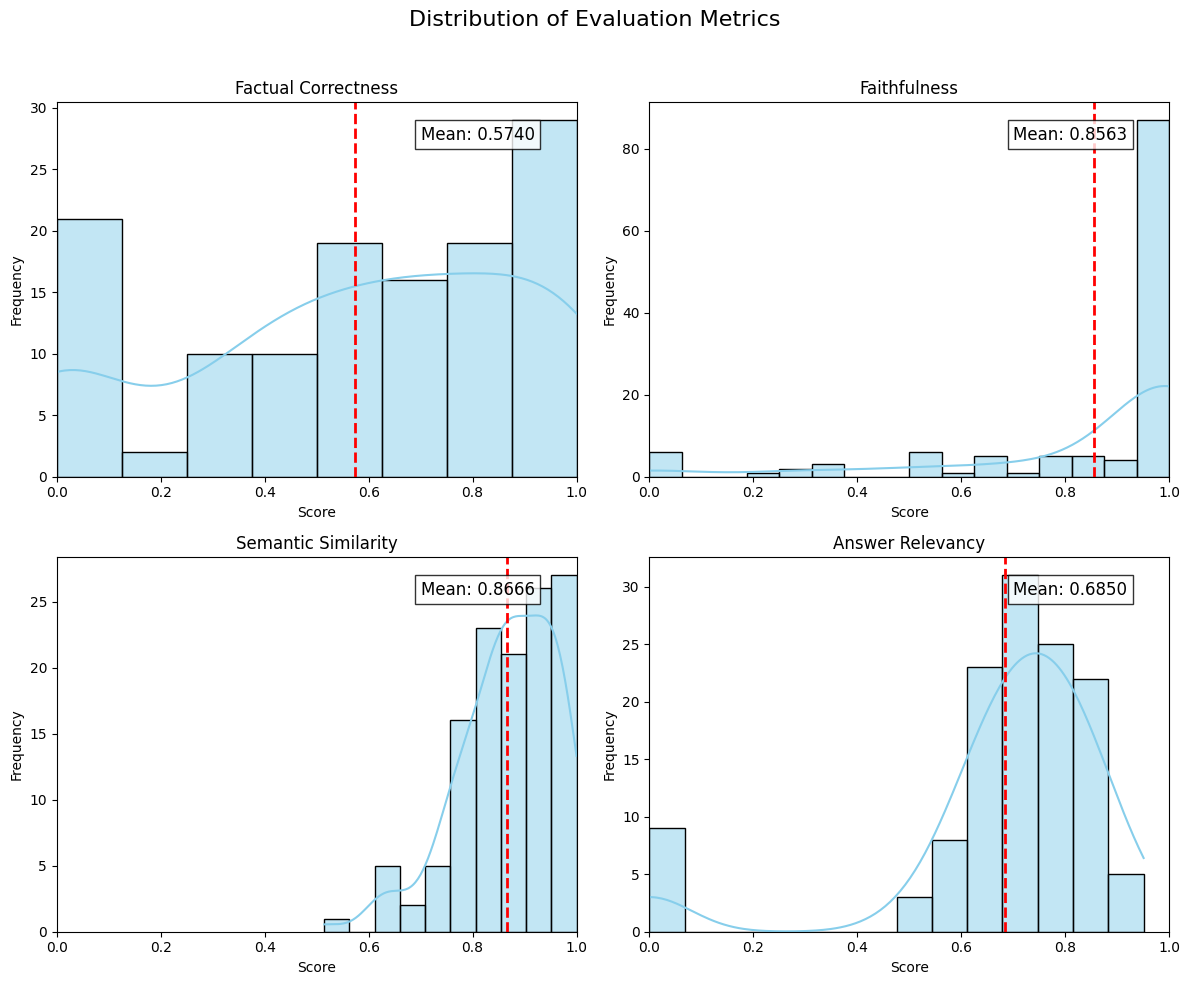

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of Evaluation Metrics', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Columns to plot
columns = ['factual_correctness', 'faithfulness', 'semantic_similarity', 'answer_relevancy']

# Create histograms for each column
for i, column in enumerate(columns):
    # Create histogram with KDE
    sns.histplot(df[column], kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    
    # Add mean line
    mean_val = df[column].mean()
    axes[i].axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
    axes[i].text(0.7, 0.9, f'Mean: {mean_val:.4f}', transform=axes[i].transAxes, 
                fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Set title and labels
    axes[i].set_title(f'{column.replace("_", " ").title()}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    
    # Set x-axis range (assuming scores are between 0 and 1)
    axes[i].set_xlim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('metric_histograms.png', dpi=300)
plt.show()